Now we will load the cats_dogs datsets from module tensorflow_datasets

In [1]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
# split the data manually into 80% training 10% testting and 10% validation
(raw_train,raw_validation,raw_test),metadata=tfds.load('cats_vs_dogs',split=['train[:80%]',
                                                                            'train[80%:90%]',
                                                                            'train[90%:]'],
                                                       with_info=True,as_supervised=True)

In [6]:
get_label_name=metadata.features['label'].int2str

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

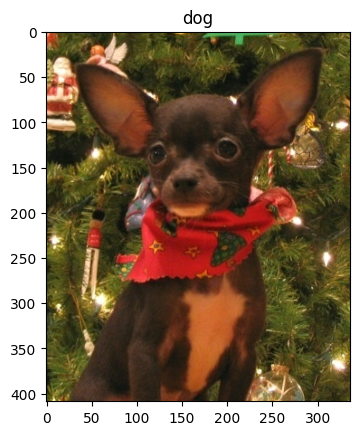

In [18]:
for image,label in raw_train.take(2):
  plt.figure
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
IMG_SIZE=160

In [22]:
IMG_SIZE=160
def format_example(image, label):
#return an image that is reshaped to IMG SIZE
  image= tf.cast(image, tf.float32)
  image =(image/127.5) - 1
  image =tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train=raw_train.map(format_example)
validation=raw_validation.map(format_example)
test=raw_test.map(format_example)




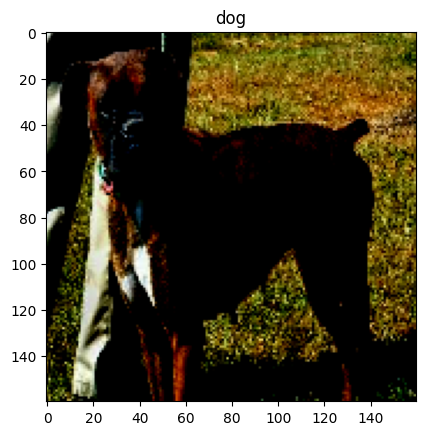

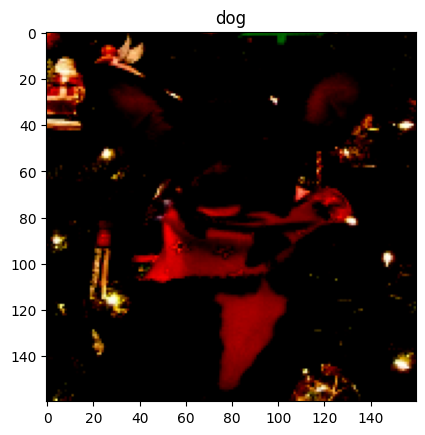

In [23]:
for image , label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [24]:
#Now if we look at the shape of an original image vs the new image we will see it has been changed.
for img,label in raw_train.take(2):
  print("Original shape", img.shape)
for img,label in train.take(2):
  print("new shape",img.shape)

Original shape (262, 350, 3)
Original shape (409, 336, 3)
new shape (160, 160, 3)
new shape (160, 160, 3)


In [25]:
#Picking a Pre-trained Model ==> The model we are going to use as the convolutional base for our model is the
#MobileNet V2 developed at google
# The model is trained on 1.4 million images and has 1000 different classes
#We want to use this model but only its convolutional base
#50 when we load in the model we will specify that we don't want to load the top (classfication) layer
#We will tell the model what input shape to expect and to use the predetermined weights from imagenet (Google DataSet)

In [26]:
IMG_SIZE=160 # define the desired size for the input image

# create the base model from the pre_trained model MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),include_top=False,
    weights="imagenet"
)

9406464/9406464 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [29]:
#The code base_model.trainable False is used to set the trainable attribute of the base_model to False.
# In TensorFlow and Keras, the trainable attribute is a boolean flag that determines
#whether the weights of a model or a specific layer #within the model should be updated during training or not.
#When trainable is set to True, the weights of the model or layer can be updated based on
#the gradients computed during backpropagation. However, when trainable is set to False, the weights remain frozen, and their values are not updated during training

In [30]:
base_model.trainable=False

In [33]:
# Adding our Classifier ==>
# Now that we have our base layer setup we can add the classfier
# Instead of flattening the feature map of the base layer we will use a global average pooling
# layer that will average the entire 5x5 area of each 20 features map and W return to us a single 1280 element vector per filter

In [32]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()

In [34]:
#Finally we will add the prediction layer that will be a single dense neuron
#We can do this because we only have two classes to predicted for

In [36]:
prediction_layer=tf.keras.layers.Dense(1)

In [37]:
#Now we will combine these layers together in a model
model = tf.keras. Sequential([
  base_model,
  global_average_layer, prediction_layer
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [39]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy (from_logits = True),
              metrics = ['accuracy'])
#We can evaluate the model right now to see how it does before training it on our new images.

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

initial_epochs = 3
validation_steps = 20
loss0 , accuracy0 = model.evaluate(validation_batches , steps = validation_steps)

20/20 [==============================] - 15s 632ms/step - loss: 0.8296 - accuracy: 0.4187


In [ ]:
# Now we can train it on our images
history = model.fit(train_batches,
epochs=initial_epochs,
validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 456s 775ms/step - loss: 0.0718 - accuracy: 0.9719 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 2/3
582/582 [==============================] - 445s 760ms/step - loss: 0.0442 - accuracy: 0.9838 - val_loss: 0.0508 - val_accuracy: 0.9828
Epoch 3/3
467/582 [=======================>......] - ETA: 1:11 - loss: 0.0390 - accuracy: 0.9855